**LSTM MODEL**
1. Install and import dependencies
2. Keypoints using MP Holistic
3. Extract Keypoints
4. Setup Folders for Collection
5. Collect Keypoints Values for Training and Testing
6. Preprocess Data and Create Labels and Features
7. Build and Train LSTM Neural Network
8. Make Predictions
9. Save Weights
10. Evaluation using Confusion Matrix and Accuracy
11. Test in Real Time

# Install and Import Dependencies

In [ ]:
!pip show tensorflow opencv-python mediapipe scikit-learn matplotlib tensorflowjs

In [ ]:
pip list

In [ ]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib tensorflowjs

In [6]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoints using MP Holistic

In [7]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [8]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR-CONVERSION BGR-to-RGB
    image.flags.writeable = False                  # Convert image to not-writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Convert image to writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR-COVERSION RGB-to-BGR
    return image, results

In [9]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [10]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
draw_landmarks(frame, results)

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [11]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['Home','help','Peace','Thanks'])

# Thirty videos worth of data
no_sequences = 60

# Videos are going to be 30 frames in length
sequence_length = 60

# Folder start
start_folder = 60

In [ ]:
signs = ['Home','help','Peace','Thanks']

parent_folder = 'MP_Data'

if not os.path.exists(parent_folder):
    os.mkdir(parent_folder)
    for sign in signs:
        sign_folder = os.path.join(parent_folder, sign)
        os.mkdir(sign_folder)
        for i in range(60):
            subfolder = os.path.join(sign_folder, str(i))
            os.mkdir(subfolder)


# Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [8]:
signs = ['Home','help','Peace','Thanks']
actions = np.array(['Home','help','Peace','Thanks'])

# Preprocess Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
label_map = {label:num for num, label in enumerate(actions)}

In [11]:
label_map

{'Home': 0, 'help': 1, 'Peace': 2, 'Thanks': 3}

In [12]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

In [13]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['Home','help','Peace','Thanks'])

# Thirty videos worth of data
no_sequences = 60

# Videos are going to be 30 frames in length
sequence_length = 60

# Folder start
start_folder = 60

In [14]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:
X = np.array(sequences)

In [16]:
y = to_categorical(labels).astype(int)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# Build and Train LSTM Neural Network

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [19]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
#While training access tensorboard
#tensorboard --logdir=.

In [24]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(60,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [25]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [26]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000


8/8 [==============================] - 4s 75ms/step - loss: 197.2077 - categorical_accuracy: 0.2412
Epoch 2/2000
8/8 [==============================] - 1s 72ms/step - loss: 268.2944 - categorical_accuracy: 0.2193
Epoch 3/2000
8/8 [==============================] - 1s 79ms/step - loss: 137.7971 - categorical_accuracy: 0.2061
Epoch 4/2000
8/8 [==============================] - 1s 73ms/step - loss: 312.1972 - categorical_accuracy: 0.2325
Epoch 5/2000
8/8 [==============================] - 1s 83ms/step - loss: 1161.6578 - categorical_accuracy: 0.2368
Epoch 6/2000
8/8 [==============================] - 1s 81ms/step - loss: 846.7051 - categorical_accuracy: 0.2544
Epoch 7/2000
8/8 [==============================] - 1s 75ms/step - loss: 413.6817 - categorical_accuracy: 0.2500
Epoch 8/2000
8/8 [==============================] - 1s 82ms/step - loss: 1282.3110 - categorical_accuracy: 0.2325
Epoch 9/2000
8/8 [==============================] - 1s 78ms/step - loss: 2269.6609 - categor

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 60, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596708 (2.28 MB)
Trainable params: 59670

In [ ]:
pip install visualkeras

c:\Users\Chetanya\AppData\Local\Programs\Python\Python311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


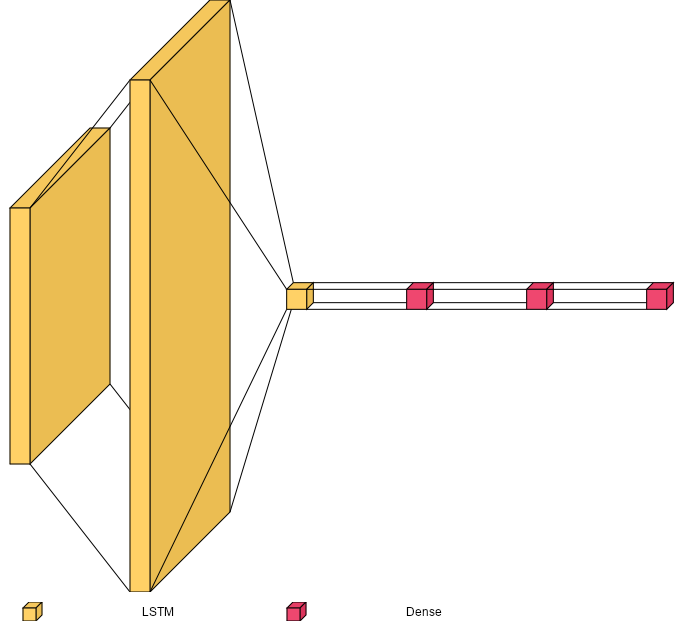

In [28]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font,spacing=100)

# Make Predictions

In [29]:
res = model.predict(X_test)

1/1 [==============================] - 0s 446ms/step


In [30]:
actions[np.argmax(res[4])]

'Thanks'

In [31]:
actions[np.argmax(y_test[4])]

'help'

# Save Weights

In [32]:
model.save('./model.h5')
model.save_weights('./model_weights.h5')

c:\Users\Chetanya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
del model

In [34]:
import tensorflow as tf
model = tf.keras.models.load_model('model.h5')

In [35]:
model.load_weights('model_weights.h5')

# Evaluation using Confusion Matrix

In [36]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [37]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 319ms/step


In [38]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [39]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[ 5,  0],
        [ 7,  0]],

       [[10,  0],
        [ 2,  0]],

       [[10,  0],
        [ 2,  0]],

       [[ 0, 11],
        [ 0,  1]]], dtype=int64)

In [40]:
accuracy_score(ytrue, yhat)

0.08333333333333333

# Realtime Test

In [41]:
from scipy import stats

In [42]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
!pip install numpy --upgrade

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf

signs = ['Home','help','Peace','Thanks']
actions = np.array(['Home','help','Peace','Thanks'])


mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR-CONVERSION BGR-to-RGB
    image.flags.writeable = False                  # Convert image to not-writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Convert image to writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR-COVERSION RGB-to-BGR
    return image, results

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])
    
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

model = tf.keras.models.load_model('model.h5')
model.load_weights('model_weights.h5')
model.summary()

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-60:]
        
        if len(sequence) == 60:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            #image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Realtime LSTM Sign Language Detection', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 60, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596708 (2.28 MB)
Trainable params: 59670

In [ ]:
pip install gtts

In [ ]:
pip install playsound

In [ ]:
import gtts
import playsound

text = input("Enter something here: ")

sound = gtts.gTTS(text,lang ="en")

sound.save("welcome.mp3")
playsound.playsound("welcome.mp3")